# Energy Aspects wick_airport_wick_airport_data Analyst case study
You are a data analyst at Energy Aspects. <br>
The gas team needs a model to help them understand gas demand in Northern Scotland. <br>
They believe Gas demand is tied up to temperatures and tasked you to forecast minimum temperatures in the next 24 months.<br>
For this exercise, you will use weather data from Wick Airport as a proxy for Northern Scotland weather.<br>
The language to be used is Python.<br>
You can use any library you may find useful for the task.<br>

### Case study assessment
- Do not overcomplexify your answers. We value our team's ability to give simple answers to simple questions
- Focus on clean code and short, high level explainations of choices
- Do not spend time tuning models to get accurate results. We will not assess you on model accuracy / tuning
- We will assess relevance of analytics, visualisations, model choice and reasonings

## Data source and description

wick_airport_weather_data.csv<br>
https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data<br>

Wick Airport<br>
Location  336500E 952200N, Lat 58.454 Lon -3.088, 36m amsl<br>
Estimated data is marked with a * after the value.<br>
Missing data (more than 2 days missing in month) is marked by  ---.<br>
Sunshine data taken from an automatic Kipp & Zonen sensor marked with a #, otherwise sunshine data taken from a Campbell Stokes recorder.<br>
- Mean daily maximum temperature (tmax): degC
- Mean daily minimum temperature (tmin): degC
- Days of air frost (af): days
- Total rainfall (rain): mm
- Total sunshine duration (sun): hours

# Import data
Import data from data/wick_airport_weather_data.csv

In [25]:
import pandas as pd
import numpy as np
import os

data_dir = "data"
filename = "wick_airport_weather_data.csv"
wick_airport_data_file_path = os.path.join(data_dir, filename)

wick_airport_data = pd.read_csv(wick_airport_data_file_path)

# Extract and transform
Make all the cleaning and transformation steps you judge necessary to analyse the data

In [26]:
import pandas as pd
import numpy as np

class DataCleaner:
    def __init__(self, df):
        self.df = df

    def generate_data_cleanliness_stats(self):
        print(self.df.info(), self.df.isna().sum())

    def drop_unnecessary_columns(self, columns_to_drop):
        self.df.drop(columns=[col for col in columns_to_drop if col in self.df.columns], inplace=True)

    def process_estimated_data(self, columns_to_check):
        for col in columns_to_check:
            if self.df[col].dtype == object:
                self.df[col] = pd.to_numeric(self.df[col].str.replace('*', ''), errors='coerce')

    def replace_placeholders_with_NaN(self, columns_to_convert):
        for column in columns_to_convert:
            if self.df[column].dtype == object:
                self.df[column] = self.df[column].replace('---', np.nan).apply(pd.to_numeric, errors='coerce')

    def combine_date_columns(self):
        if "date" not in self.df.columns:
            self.df['date'] = pd.to_datetime(self.df['yyyy'].astype(str) + '-' + self.df['mm'].astype(str) + '-01')
            self.df.set_index('date', inplace=True)

    def interpolate_missing_values(self, columns, method='linear'):
        for column in columns:
            if self.df[column].isnull().any():
                self.df[column] = self.df[column].interpolate(method=method)

    def check_data_integrity(self):
        temp_range = (-30, 35)
        rain_range = (0, 1000)
        temp_outliers = self.df[~self.df['tmax'].between(*temp_range) | ~self.df['tmin'].between(*temp_range)]
        rain_outliers = self.df[~self.df['rain'].between(*rain_range)]
        if not temp_outliers.empty:
            print("Potential temperature errors found:")
            print(temp_outliers[['tmax', 'tmin']])
        if not rain_outliers.empty:
            print("Potential rainfall errors found:")
            print(rain_outliers['rain'])


cleaner = DataCleaner(wick_airport_data)
cleaner.generate_data_cleanliness_stats()
cleaner.drop_unnecessary_columns(['sun', 'status'])
cleaner.process_estimated_data(['tmax', 'tmin', 'rain'])
cleaner.replace_placeholders_with_NaN(['tmax', 'tmin', 'af', 'rain'])
cleaner.combine_date_columns()
cleaner.interpolate_missing_values(['tmin', 'tmax'], method='time')

cleaner.generate_data_cleanliness_stats()
cleaner.check_data_integrity()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   yyyy    1302 non-null   int64 
 1   mm      1302 non-null   int64 
 2   tmax    1302 non-null   object
 3   tmin    1302 non-null   object
 4   af      1302 non-null   object
 5   rain    1302 non-null   object
 6   sun     1302 non-null   object
 7   status  6 non-null      object
dtypes: int64(2), object(6)
memory usage: 81.5+ KB
None yyyy         0
mm           0
tmax         0
tmin         0
af           0
rain         0
sun          0
status    1296
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1302 entries, 1914-01-01 to 2022-06-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yyyy    1302 non-null   int64  
 1   mm      1302 non-null   int64  
 2   tmax    1302 non-null   float64
 3   tmin    1302 non-null   float64

# Data exploration and charting
Perform Exploratory Data Analysis on the dataset.<br>
Present your findings in a few lines and charts.

count    1302.000000
mean        5.026482
std         3.405321
min        -2.900000
25%         2.225000
50%         4.550000
75%         8.100000
max        12.000000
Name: tmin, dtype: float64


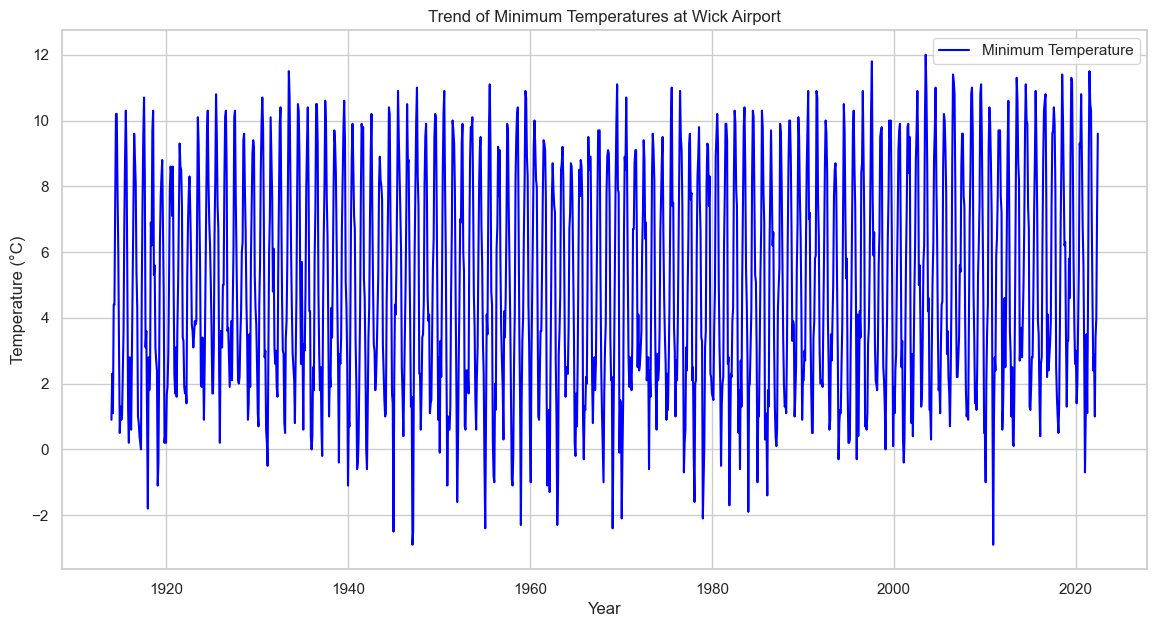

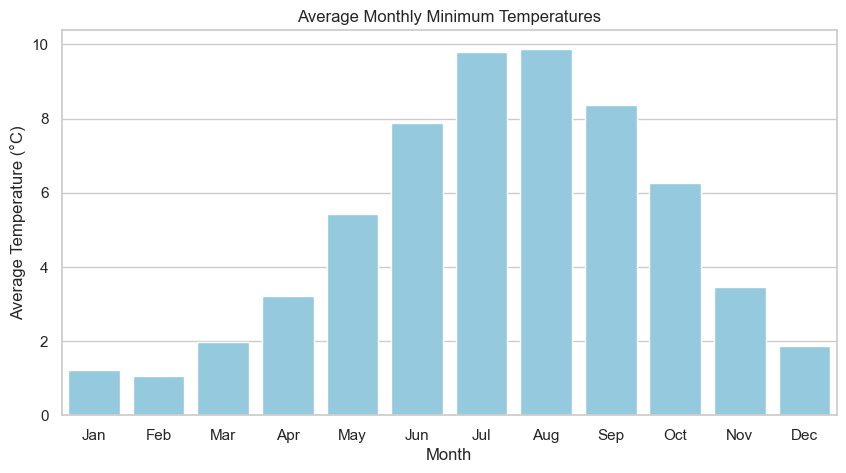

Stationarity Test (Minimum Temperature):
ADF Statistic: -4.639354
p-value: 0.000109
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

class DataExplorer:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.column_name_taxonomy = {
            "tmin": "Minimum Temperature",
            "tmax": "Maximum Temperature",
        }
        sns.set(style="whitegrid")  # Set visual style for all plots

    def descriptive_stats(self):
        stats = self.df[self.column_name].describe()
        print(stats)

    def plot_min_temps(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.df.index, self.df[self.column_name], label=self.column_name_taxonomy[self.column_name], color='blue')
        plt.title(f'Trend of {self.column_name_taxonomy[self.column_name]}s at Wick Airport')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

    def plot_seasonality(self):
        self.df['month'] = self.df.index.month
        monthly = self.df.groupby('month')[self.column_name].mean()

        plt.figure(figsize=(10, 5))
        sns.barplot(x=monthly.index, y=monthly.values, color='skyblue')
        plt.title(f'Average Monthly {self.column_name_taxonomy[self.column_name]}s')
        plt.xlabel('Month')
        plt.ylabel('Average Temperature (°C)')
        plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.show()

    def test_stationarity(self):
        result = adfuller(self.df[self.column_name].dropna())  # Dickey-Fuller test
        print(f"Stationarity Test ({self.column_name_taxonomy[self.column_name]}):")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))


explorer = DataExplorer(wick_airport_data, "tmin")

explorer.descriptive_stats()
explorer.plot_min_temps()
explorer.plot_seasonality()
explorer.test_stationarity()

# Modelling
Choose a model, backtest it and generate forecasts for the 24 months ahead.<br>
Explain your model choice in a few lines and present backtesting / forecasting results using tables and charts understandable for analysts who do not write code or build statistical models.


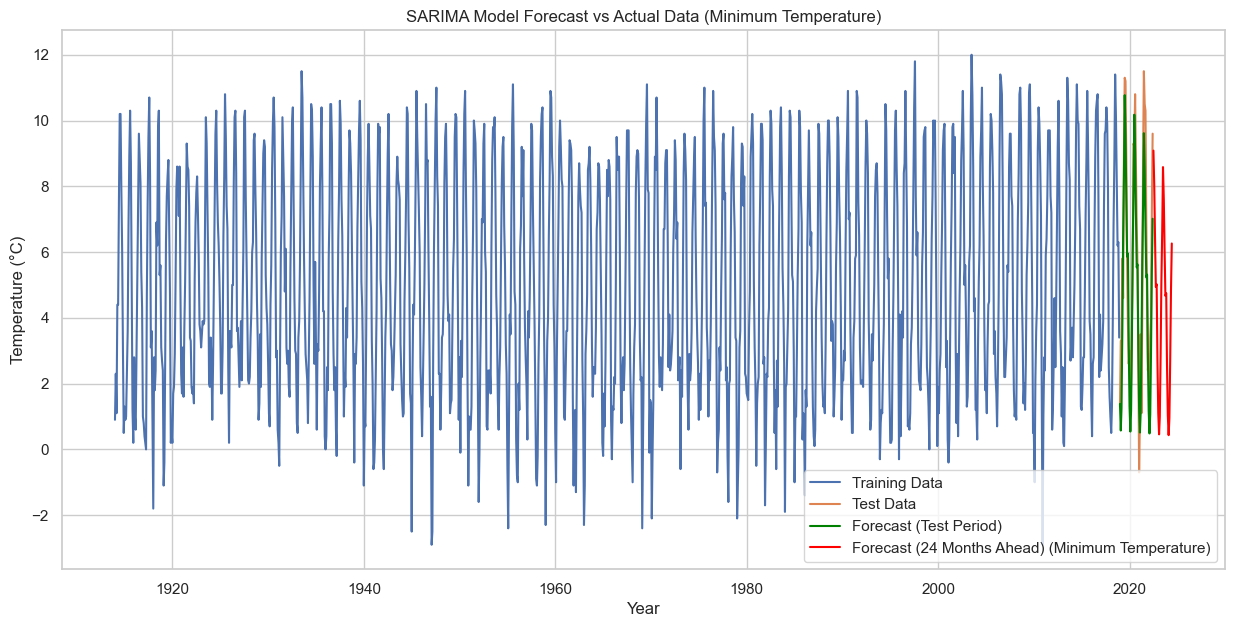

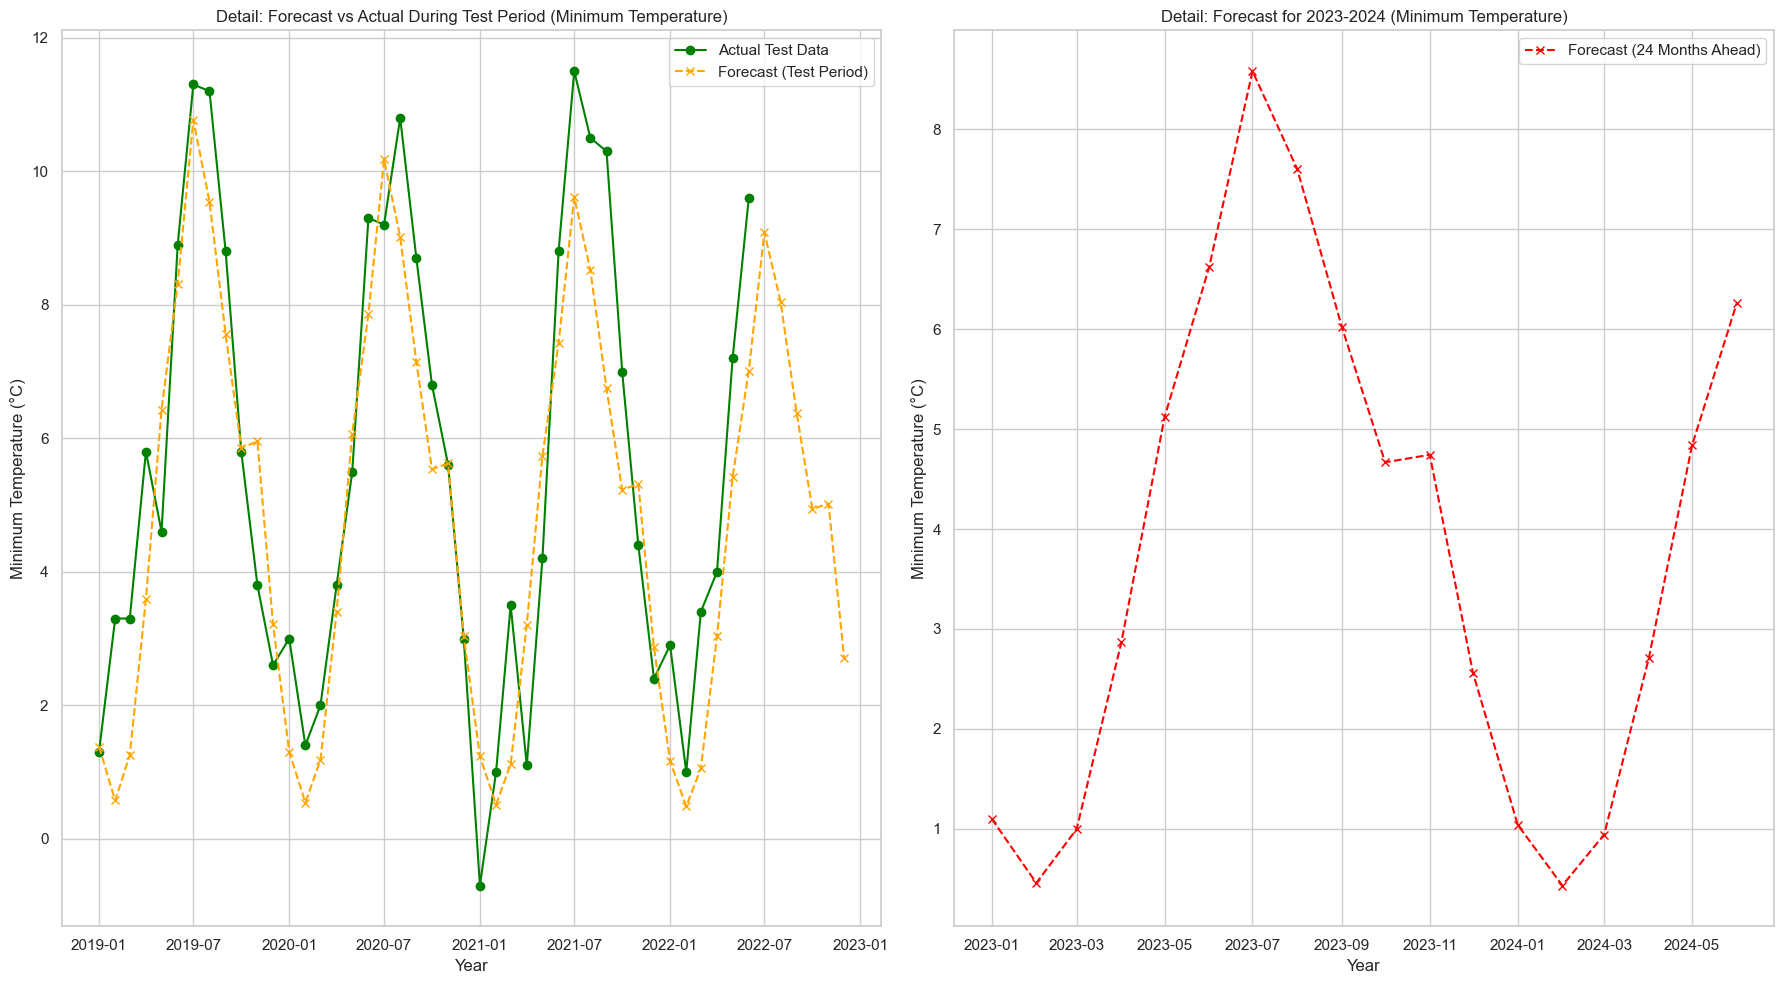

Forecast Accuracy Metrics (Minimum Temperature):
{'MAE': 1.368552972718373, 'RMSE': 1.595932172062968, 'MAPE': 39.02673121775659}


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

class SARIMAModeller:
    def __init__(self, df, column_name):
        self.df = df
        self.column_name = column_name
        self.column_name_taxonomy = {
            "tmin": "Minimum Temperature",
            "tmax": "Maximum Temperature",
        }
        self.df_series = df[self.column_name]

    def interpolate_missing_data(self):
        self.df[self.column_name] = self.df[self.column_name].interpolate(method='time')

    def train_test_split_custom(self, train_end_year, test_end_year):
        self.df.index = pd.date_range(start=self.df.index[0], periods=len(self.df), freq='MS')
        train_data = self.df_series[:str(train_end_year)]
        test_data = self.df_series[str(train_end_year + 1):str(test_end_year)]
        return train_data, test_data

    def identify_optimal_sarima_parameters(self):
        sarima_model = auto_arima(self.df, seasonal=True, m=12, trace=True,
                                  error_action='ignore', suppress_warnings=True,
                                  stepwise=True, n_fits=50)
        sarima_model.summary()
        return sarima_model.order, sarima_model.seasonal_order

    def fit_sarima(self, train_data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12)):
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, freq="MS")
        sarima_result = model.fit(disp=False)
        return sarima_result

    def forecast_sarima(self, sarima_result, test_data, months):
        last_date_in_test_data = test_data.index[-1]
        total_months = months + (last_date_in_test_data.year - test_data.index[0].year) * 12 + \
                       (last_date_in_test_data.month - test_data.index[0].month + 1)
        forecast = sarima_result.get_forecast(steps=total_months)
        forecast_index = pd.date_range(test_data.index[0], periods=total_months, freq='MS')
        return forecast, forecast_index

    def plot_forecast(self, train_data, test_data, forecast_series, forecasting_months):
        plt.figure(figsize=(15, 7))
        plt.plot(train_data, label='Training Data')
        plt.plot(test_data, label='Test Data')
        plt.plot(forecast_series[:len(test_data)], label='Forecast (Test Period)', color='green')
        plt.plot(forecast_series[len(test_data):], label=f'Forecast ({forecasting_months} Months Ahead) ({self.column_name_taxonomy[self.column_name]})', color='red')
        plt.title(f'SARIMA Model Forecast vs Actual Data ({self.column_name_taxonomy[self.column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Temperature (°C)')
        plt.legend()
        plt.show()

    def plot_forecast_narrow(self, test_data, forecast_series, forecasting_months):
        plt.figure(figsize=(18, 10))

        # Subplot 1: Test Data vs Forecast (Test Period)
        plt.subplot(1, 2, 1)
        test_period_end_year = test_data.index[-1].year
        plt.plot(test_data, label='Actual Test Data', color='green', marker='o')
        plt.plot(forecast_series[:str(test_period_end_year)], label='Forecast (Test Period)', color='orange', marker='x', linestyle='--')
        plt.title(f'Detail: Forecast vs Actual During Test Period ({self.column_name_taxonomy[self.column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Minimum Temperature (°C)')
        plt.legend()

        # Subplot 2: Forecast for the Next 24 Months
        plt.subplot(1, 2, 2)
        forecast_future_start = str(test_period_end_year + 1)
        forecast_future_end = str(test_period_end_year + 2)
        plt.plot(forecast_series[forecast_future_start:forecast_future_end], label=f'Forecast ({forecasting_months} Months Ahead)', color='red', marker='x', linestyle='--')
        plt.title(f'Detail: Forecast for {forecast_future_start}-{forecast_future_end} ({self.column_name_taxonomy[self.column_name]})')
        plt.xlabel('Year')
        plt.ylabel('Minimum Temperature (°C)')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def calculate_forecast_accuracy_metrics(self, test_data, forecast_data):
        mae = mean_absolute_error(test_data, forecast_data[:len(test_data)])
        rmse = np.sqrt(mean_squared_error(test_data, forecast_data[:len(test_data)]))
        mape = np.mean(np.abs((test_data - forecast_data[:len(test_data)]) / test_data)) * 100
        metrics = {
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        }
        return metrics

modeller = SARIMAModeller(wick_airport_data, 'tmin')

find_optimum_parameters = False
modeller.interpolate_missing_data()
train_data, test_data = modeller.train_test_split_custom(train_end_year=2018, test_end_year=2022)
if find_optimum_parameters:
    order, seasonal_order = modeller.identify_optimal_sarima_parameters()
else:
    stored_optimum_results = {
        "tmin": {"order": (1, 0, 0), "seasonal_order": (1, 0, 0, 12)},
        "tmax": {"order": (3, 1, 1), "seasonal_order": (2, 0, 1, 12)}
    }
    order = stored_optimum_results[modeller.column_name]["order"]
    seasonal_order = stored_optimum_results[modeller.column_name]["seasonal_order"]

sarima_result = modeller.fit_sarima(train_data, order, seasonal_order)
forecast, forecast_index = modeller.forecast_sarima(sarima_result, test_data, 24)
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

modeller.plot_forecast(train_data, test_data, forecast_series, forecasting_months=24)
modeller.plot_forecast_narrow(test_data, forecast_series, forecasting_months=24)

metrics = modeller.calculate_forecast_accuracy_metrics(test_data, forecast_series)
print(f"Forecast Accuracy Metrics ({modeller.column_name_taxonomy[modeller.column_name]}):")
print(metrics)

## Minimum Temperature Analysis
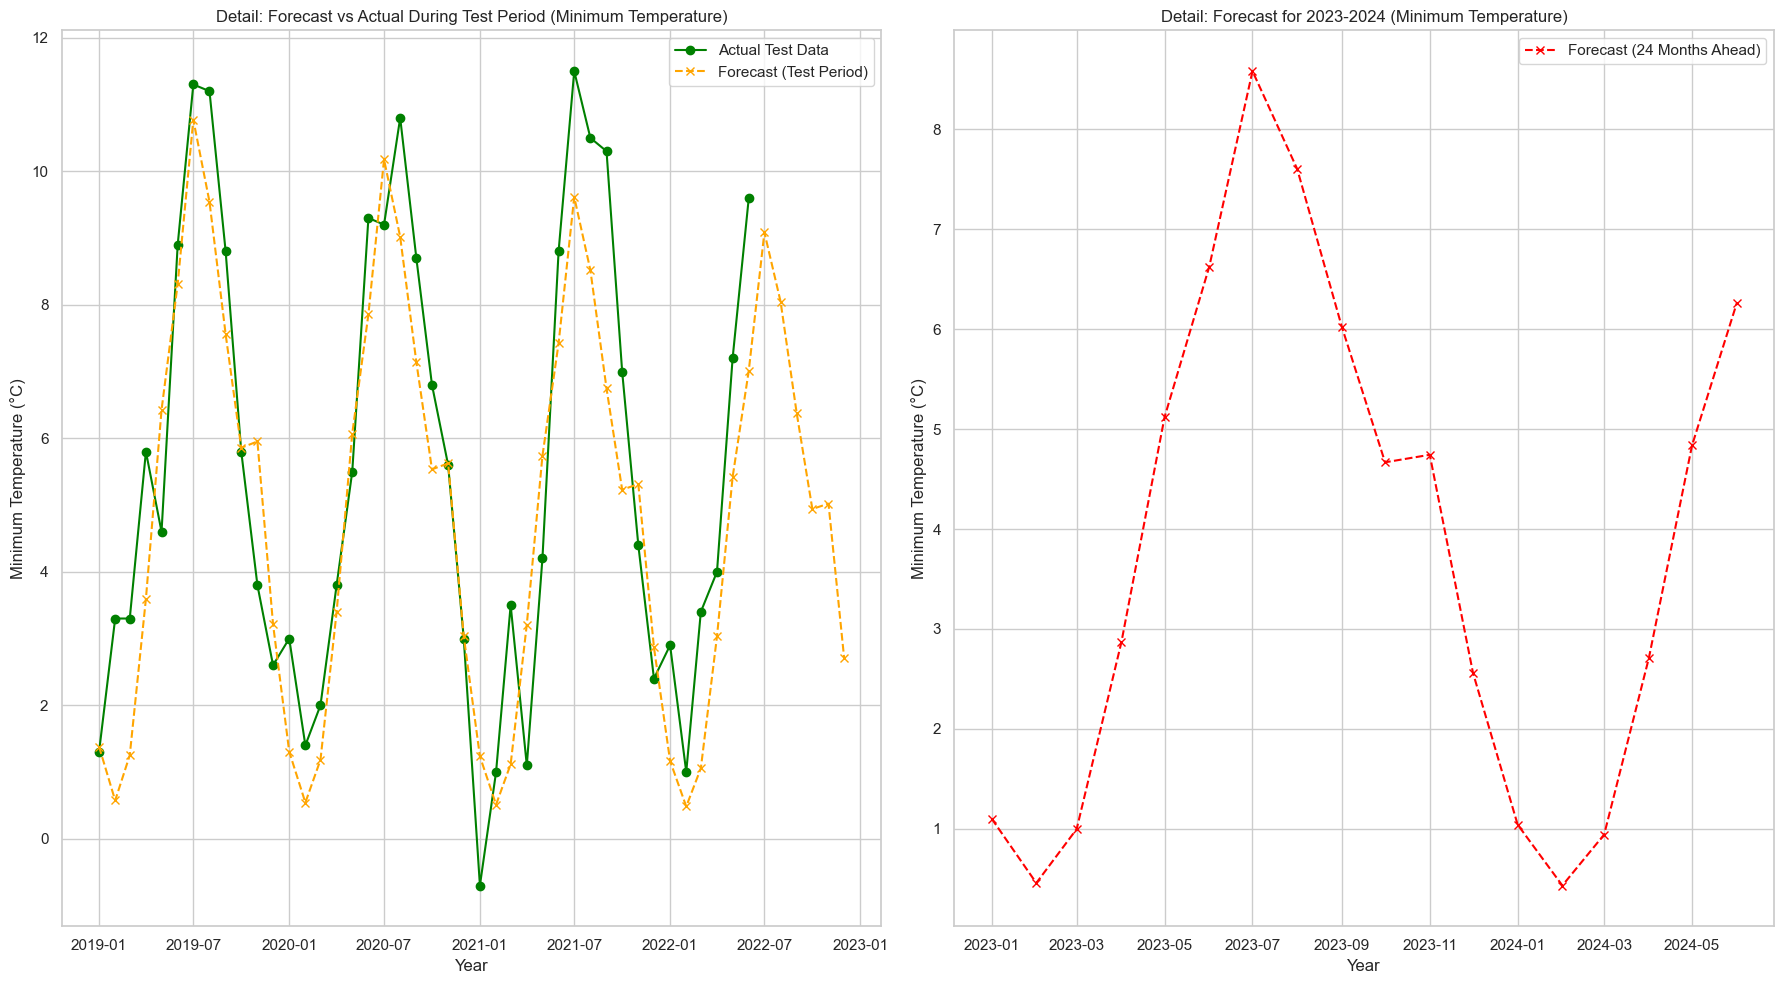


- **Forecast Accuracy**: The model's Mean Absolute Error of 1.37°C and Root Mean Square Error of 1.60°C suggest moderate accuracy.
- **Percentage Error**: A high Mean Absolute Percentage Error of 39.03% indicates the model may not perform well with lower temperature values, where relative errors become more pronounced.
- **Error Variability**: The standard deviation of the forecast errors shows significant variability, emphasising inconsistencies in the model’s predictive accuracy across different times.
- **Test Data Performance**: Graphs show the model captures seasonal trends but reveals discrepancies in magnitude and timing against actual observations.
- **Future Forecast (2023-2024)**: Forecasts predict continuing seasonal patterns but may exhibit overfitting to past seasonal extremes.
- **Visual Analysis**: Demonstrates general trend and seasonality capture, yet highlights the need for model adjustments to close the gap between forecasted and actual values.